# ENS Data Challenge 2020 - Valeo

Ceci est un NoteBook 'type' utilisé dans le cadre du Challenge de données 2020 de l'ENS proposé par Valeo : https://challengedata.ens.fr/participants/challenges/36/

Sur cette base, plusieurs modèles ont été mis en oeuvre et certains paramètres ont donc été modifiés :
    - Le modèle NN prédictif
    - Le ré équilibrage des classes du Label

Et le score final obtenu (0.7633 Public / 0.7424 Final) est le produit d'une moyenne des 10 meilleurs soumissions.

## Data Preparation

### Initialisation des données et découverte

#### Chargement des librairies et des données (train + test + Y) 

In [1]:
import numpy as np
import pandas as pd

train = pd.read_csv('data/traininginputs.csv')
shp   = train.shape[0]
full  = train.append(pd.read_csv('data/testinputs.csv'), sort=False)
full.reset_index(drop=True, inplace=True)
train = None
y     = pd.read_csv('data/trainingoutput.csv')
tid   = full['PROC_TRACEINFO'].values[shp:]

#### Redéfinition des types des columns en 'float32' (gain en performance : i.e. float64)

In [2]:
for i in full.columns:
    if(i=='PROC_TRACEINFO'):
        continue
    full[i] = full[i].astype('float32')

#### Visualisation de la structure des données

In [3]:
full

,PROC_TRACEINFO,OP070_V_1_angle_value,OP090_SnapRingPeakForce_value,OP070_V_2_angle_value,OP120_Rodage_I_mesure_value,OP090_SnapRingFinalStroke_value,OP110_Vissage_M8_torque_value,OP100_Capuchon_insertion_mesure,OP120_Rodage_U_mesure_value,OP070_V_1_torque_value,OP090_StartLinePeakForce_value,OP110_Vissage_M8_angle_value,OP090_SnapRingMidPointForce_val,OP070_V_2_torque_value
0,I-B-XA1207672-190429-00688,180.399994,190.509995,173.100006,113.639999,12.04,12.16,NaN,11.97,6.62,26.370001,18.799999,109.620003,6.60
1,I-B-XA1207672-190828-00973,138.699997,147.699997,163.500000,109.769997,12.12,12.19,0.39,11.97,6.41,21.030001,18.500000,105.480003,6.40
2,I-B-XA1207672-190712-03462,180.899994,150.869995,181.199997,109.790001,11.86,12.24,NaN,11.97,6.62,25.809999,17.500000,100.029999,6.61
3,I-B-XA1207672-190803-00051,173.500000,159.559998,151.800003,113.250000,11.82,12.35,0.39,11.97,6.62,24.620001,15.600000,104.940002,6.61
4,I-B-XA1207672-190508-03248,174.500000,172.289993,177.500000,112.879997,12.07,12.19,NaN,11.97,6.62,29.219999,33.599998,99.190002,6.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42511,I-B-XA1207672-190905-03031,149.199997,135.669998,149.800003,110.089996,12.11,12.26,0.41,11.97,6.40,22.049999,15.000000,100.870003,6.40
42512,I-B-XA1207672-190531-00225,158.000000,164.300003,178.600006,113.610001,11.90,12.27,NaN,11.97,6.62,20.740000,15.500000,86.970001,6.61
42513,I-B-XA1207672-190424-03040,164.699997,183.570007,193.800003,109.400002,12.06,12.26,NaN,11.97,6.61,26.160000,40.200001,106.290001,6.60
42514,I-B-XA1207672-190715-00155,165.399994,145.710007,156.500000,108.250000,11.85,12.25,NaN,11.97,6.61,27.180000,18.400000,98.599998,6.63


#### Visualisation grahique bivariée des données par classe du Label (0 / 1)

<ipython-input-4-49ef53df22bd>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


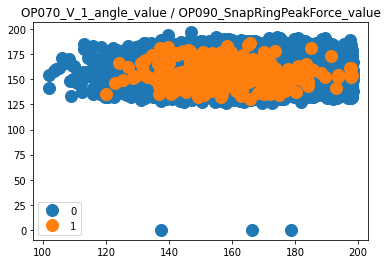

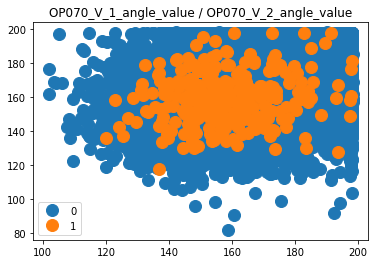

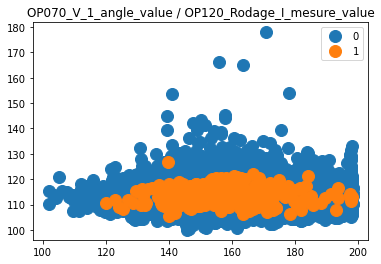

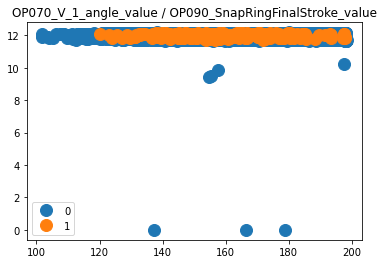

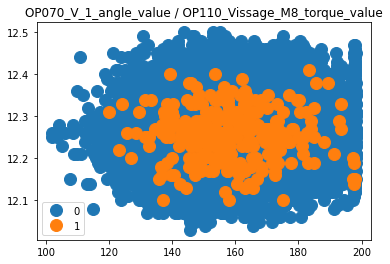

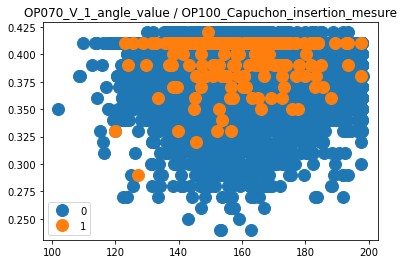

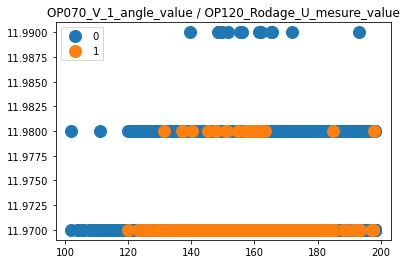

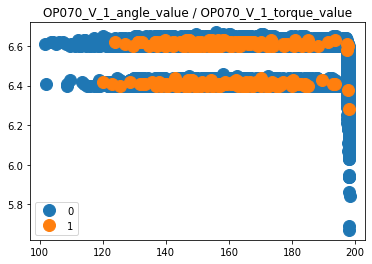

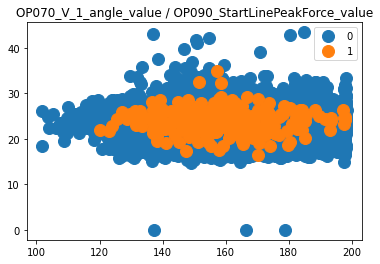

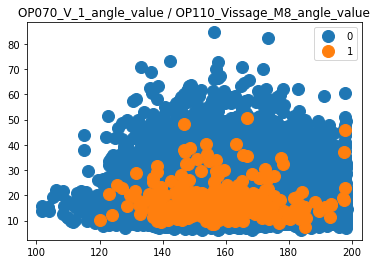

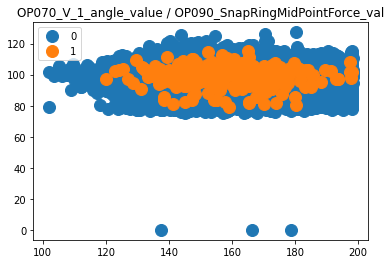

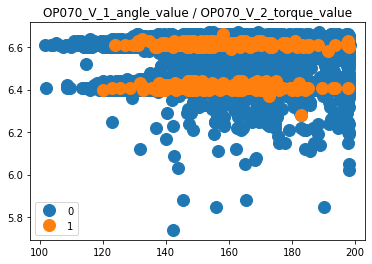

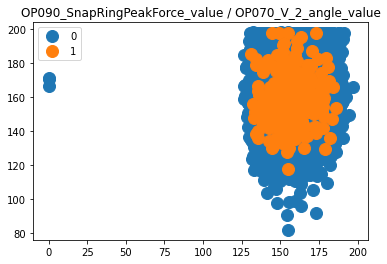

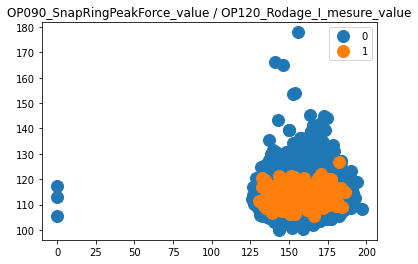

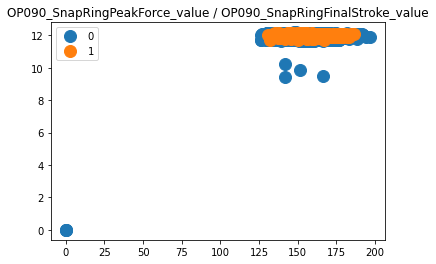

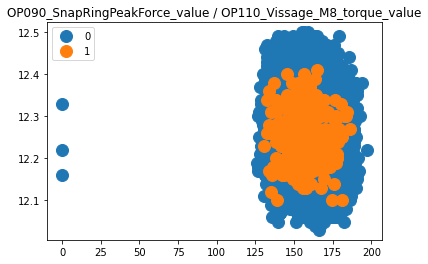

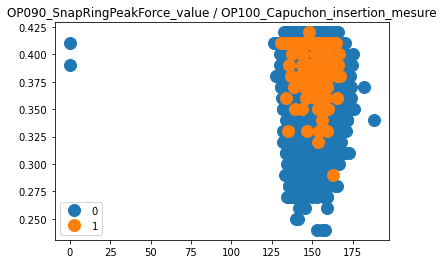

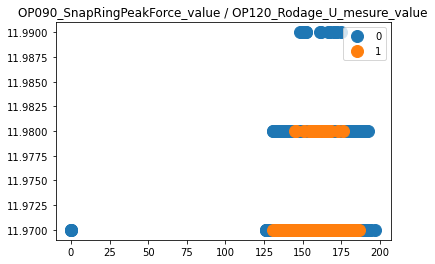

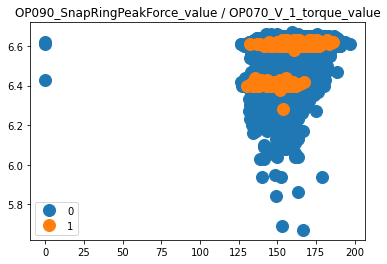

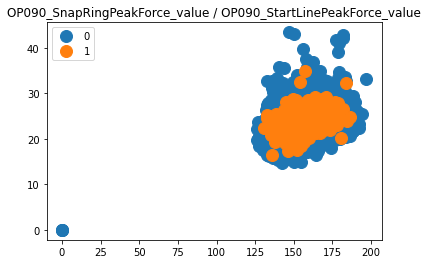

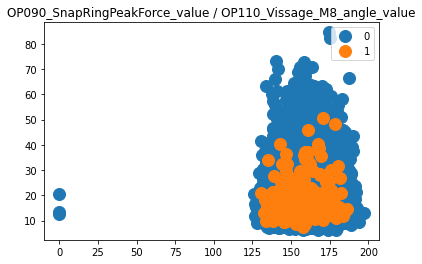

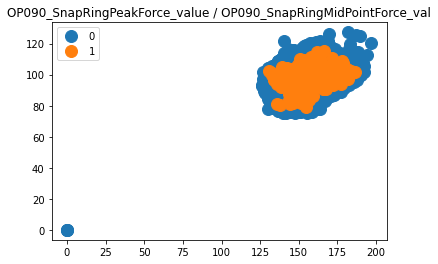

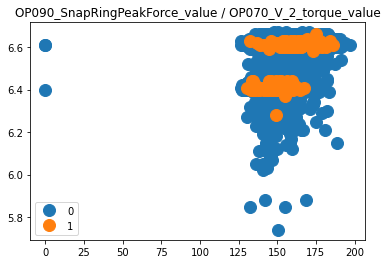

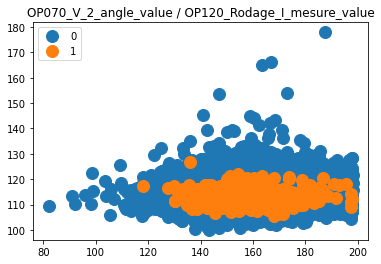

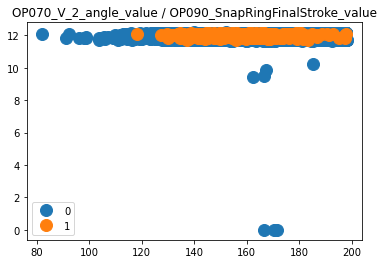

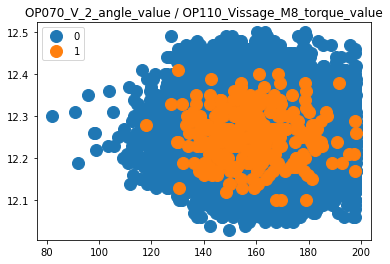

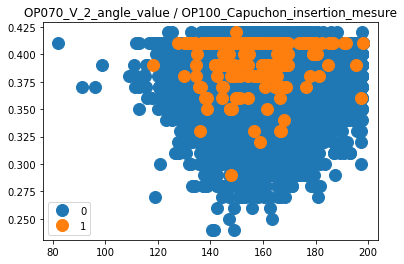

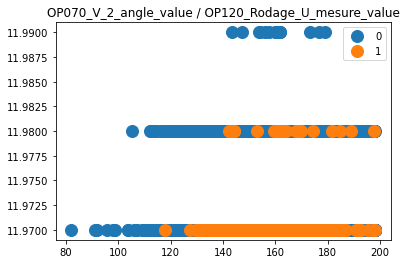

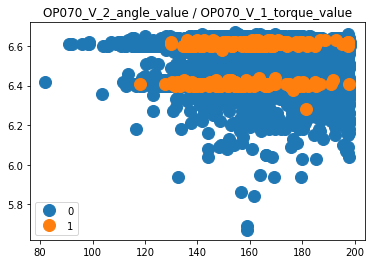

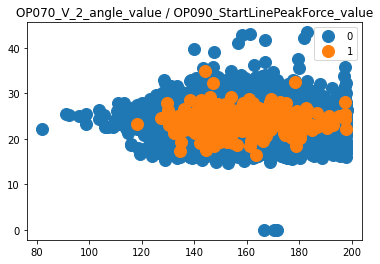

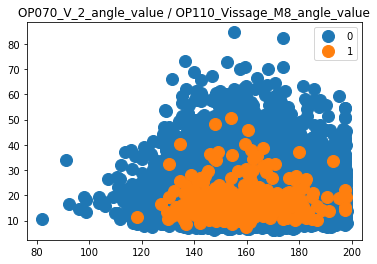

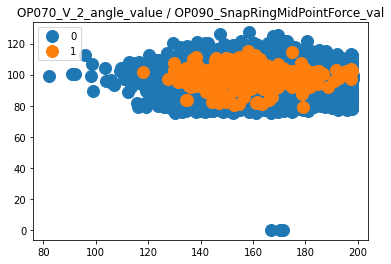

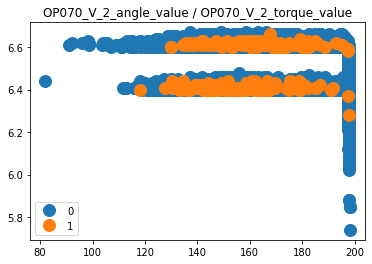

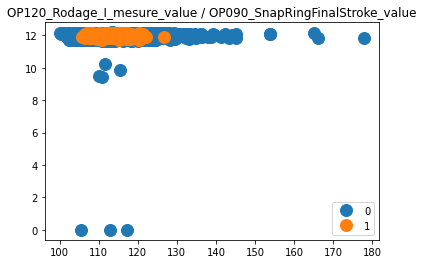

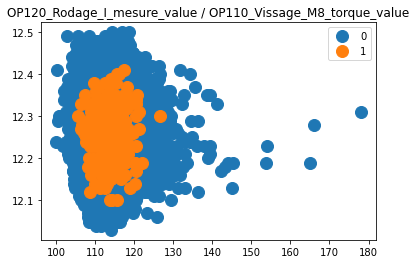

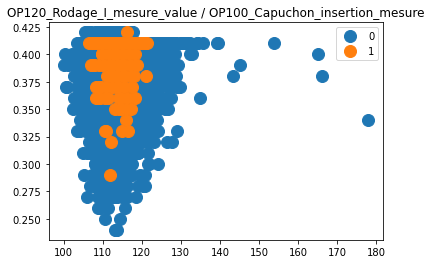

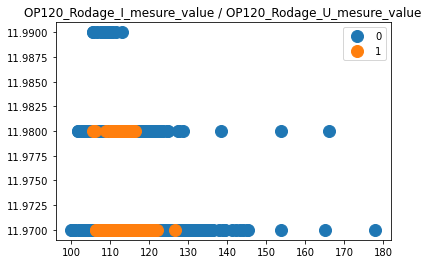

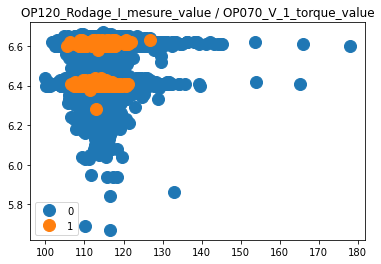

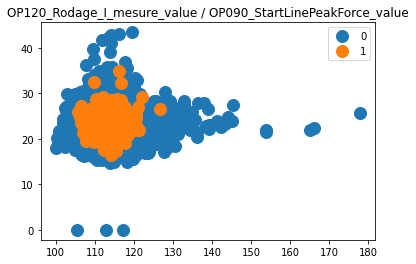

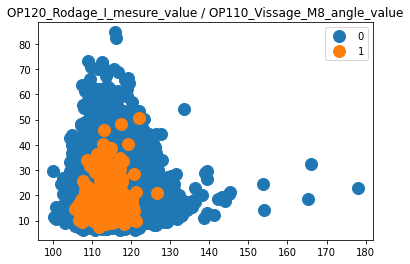

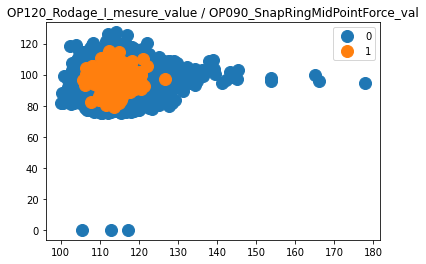

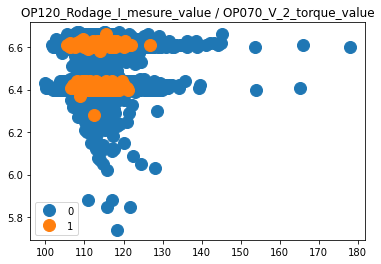

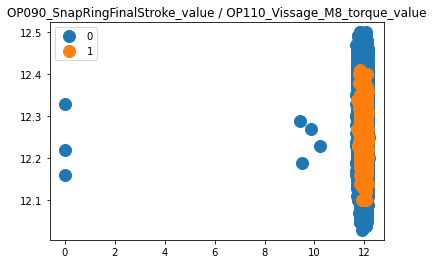

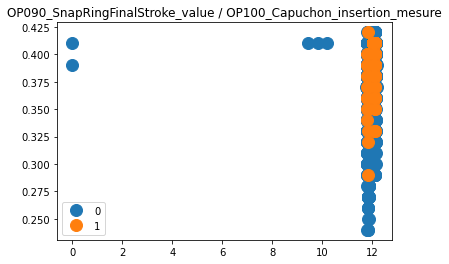

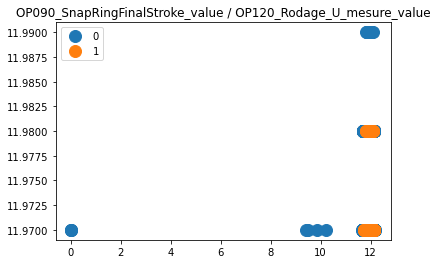

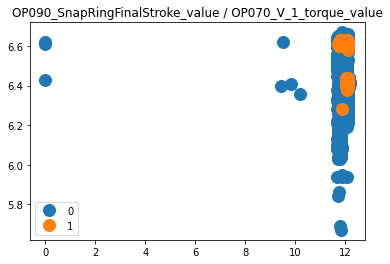

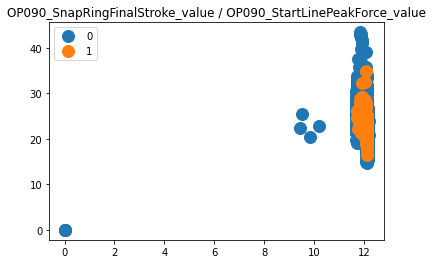

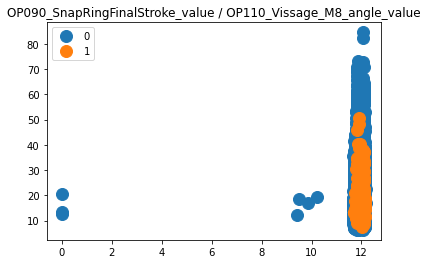

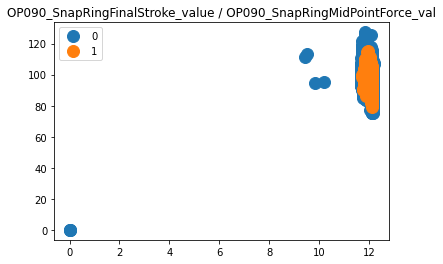

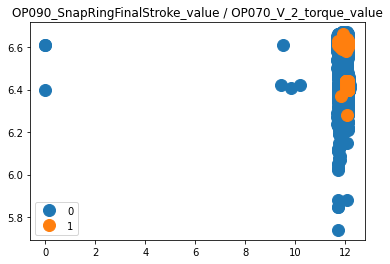

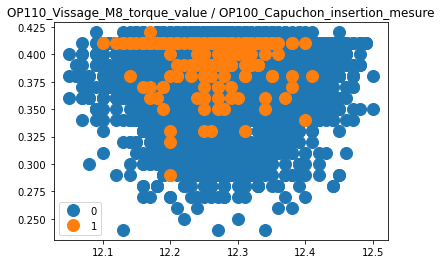

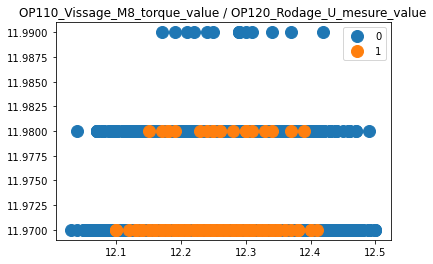

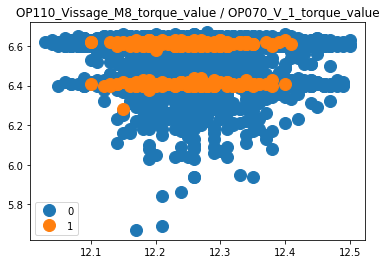

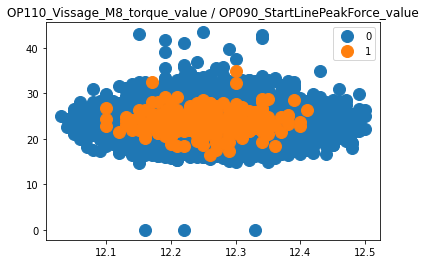

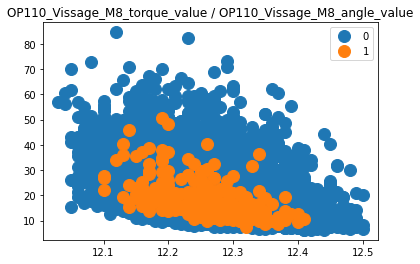

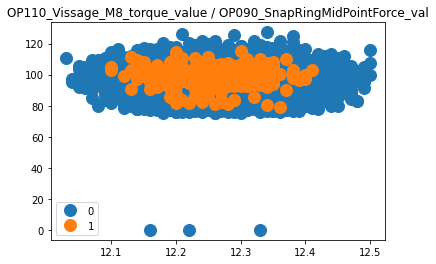

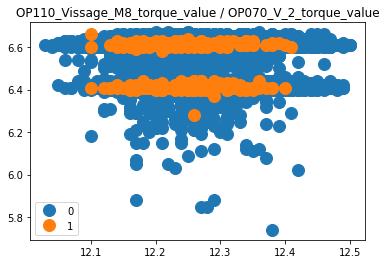

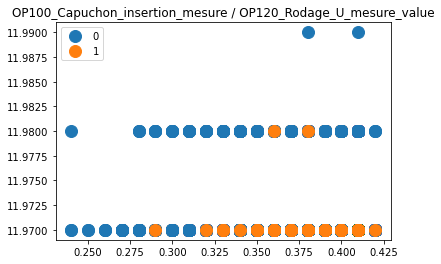

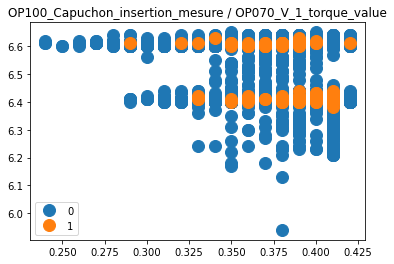

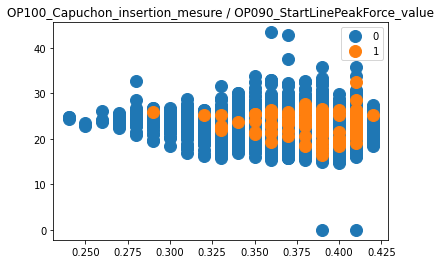

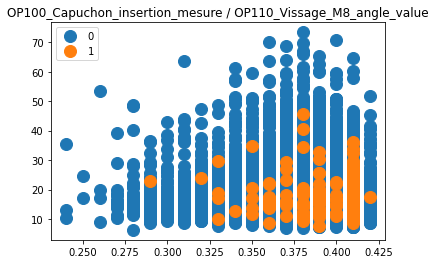

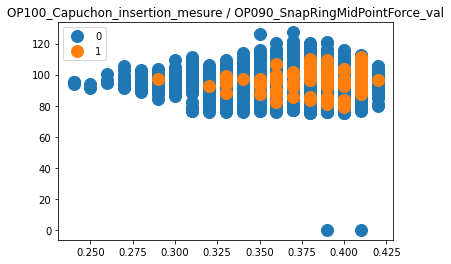

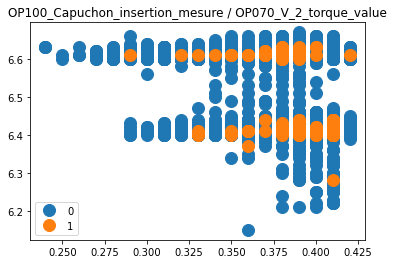

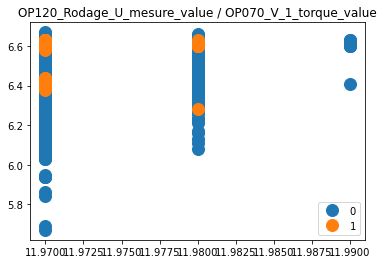

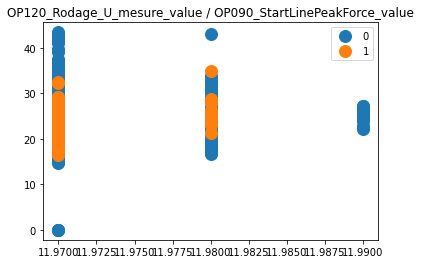

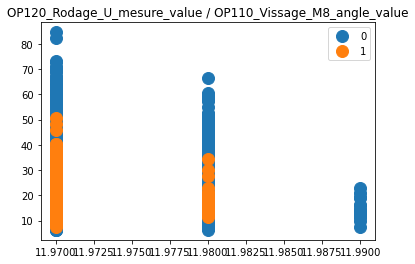

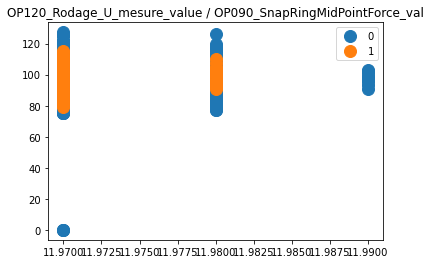

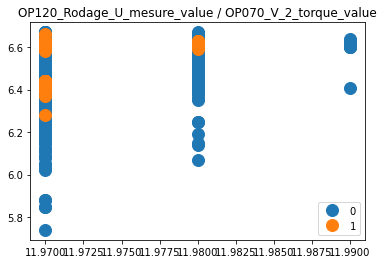

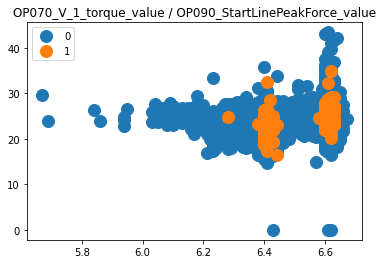

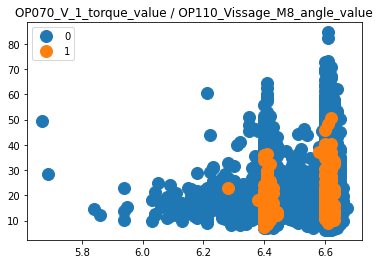

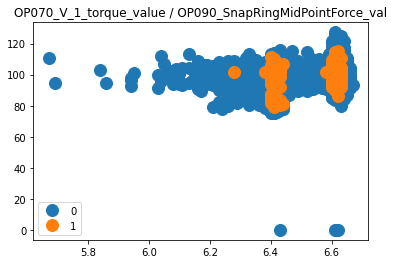

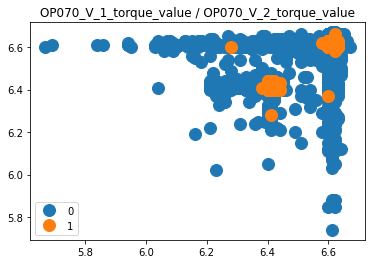

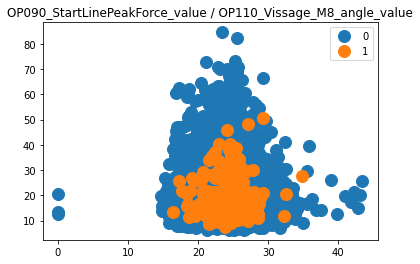

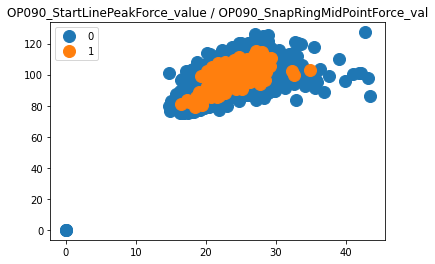

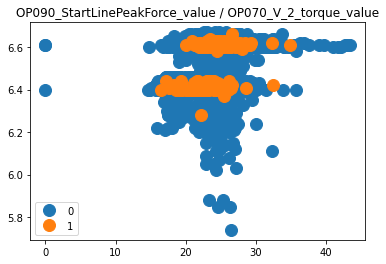

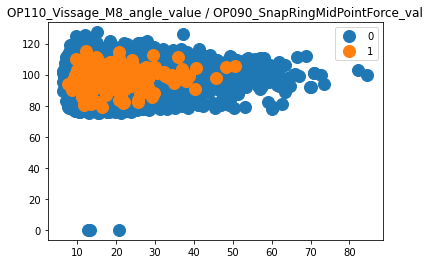

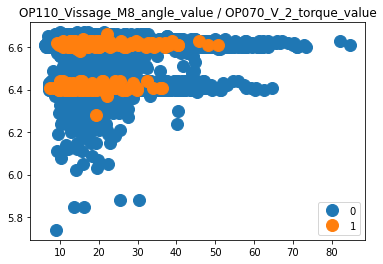

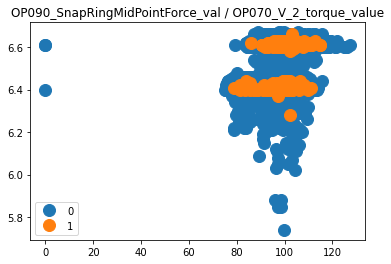

In [4]:
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple

for i in np.arange(1,14):
    for j in np.arange(i+1,14):
        df = pd.concat([full.iloc[:shp,[i,j]], y.iloc[:,1]], sort = False, axis = 1)
        df.columns=['a','b','y']
        groups = df.groupby('y')

        fig, ax = plt.subplots()
        for name, group in groups:
            ax.plot(group.a, group.b, marker='o', linestyle='', ms=12, label=name)
            ax.set_title(full.columns.values[i] + " / " + full.columns.values[j])
        ax.legend()

plt.show()

**/!\ Pas de frontière de décision claire entre les différentes classes selon les binômes de features**

#### Visualisation des données manquantes

In [5]:
full.isna().sum()

PROC_TRACEINFO                         0
OP070_V_1_angle_value                  0
OP090_SnapRingPeakForce_value          0
OP070_V_2_angle_value                  0
OP120_Rodage_I_mesure_value            0
OP090_SnapRingFinalStroke_value        0
OP110_Vissage_M8_torque_value          0
OP100_Capuchon_insertion_mesure    22987
OP120_Rodage_U_mesure_value            0
OP070_V_1_torque_value                 0
OP090_StartLinePeakForce_value         0
OP110_Vissage_M8_angle_value           0
OP090_SnapRingMidPointForce_val        0
OP070_V_2_torque_value                 0
dtype: int64

### Création de nouvelles veriables

#### Récupération des informations relatives à la Date et l'incrément inclus dans l'identifiant unique (PROC_TRACEINFO

In [6]:
dt = pd.to_datetime(["20"+x[14:20] for x in full['PROC_TRACEINFO'].values])
full['month']   = dt.month
full['wday']    = dt.weekday
full['day_num'] = dt.day
full['day']     = dt.day/dt.days_in_month
full['count']   = np.asarray([x[21:26] for x in full['PROC_TRACEINFO'].values]).astype(int)

#### Calcul du nombre d'individus par "mois/jour du mois" & par "mois"

In [8]:
full = full.merge(full[['month','day_num']].reset_index().groupby(['month','day_num']).count().reset_index().rename(columns={'index':'day_count'}),
                  how='left', on=['month','day_num'])
full = full.merge(full[['month']].reset_index().groupby(['month']).count().reset_index().rename(columns={'index':'month_count'}),
                  how='left', on=['month'])

#### Transformation des variables temporelles (https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/)

In [9]:
full['monthx'] = np.sin(2*np.pi*full['month'].values/12)
full['monthy'] = np.cos(2*np.pi*full['month'].values/12)
full['wdayx']  = np.sin(2*np.pi*full['wday'].values/7)
full['wdayy']  = np.cos(2*np.pi*full['wday'].values/7)
full['dayx']   = np.sin(2*np.pi*full['day'].values)
full['dayy']   = np.cos(2*np.pi*full['day'].values)

#### Classification Weekend ou non

In [10]:
full['we']     = 0
full['we'].iloc[np.where((full['wday'].values==5) | (full['wday'].values==6))[0]] = 1

/home/python/anaconda3/envs/my_env/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


#### Création d'autres variables (sommes cumulées par mois/jour du mois, quantités relatives de pièces produites, etc.)

In [12]:
full.sort_values('PROC_TRACEINFO', inplace=True)
full['count_cumsum'] = full[['month','day_num','count']].groupby(['month','day_num']).cumsum().values

In [13]:
full['countx'] = np.sin(2*np.pi*full['count'].values/np.max(full['count']))
full['county'] = np.cos(2*np.pi*full['count'].values/np.max(full['count']))

In [14]:
full.sort_index(inplace=True)
full['per_count_cumsum'] = full['count_cumsum']/np.max(full['count_cumsum'])
full['per_count_max']    = full['count']/np.max(full['count'])
full['per_count_mean']   = full['count']/np.mean(full['count'])
full['per_count_median'] = full['count']/np.median(full['count'])
full['per_count_var']    = full['count']/np.var(full['count'])

In [15]:
full = full.merge(full[['month','count']].groupby(['month']).max().rename(columns={'count':'month_count_max'}), how='left', on='month')
full['per_month_max_count'] = full['count']/full['month_count_max']
full.drop(columns=['month_count_max'], inplace=True)

full = full.merge(full[['wday','count']].groupby(['wday']).max().rename(columns={'count':'wday_count_max'}), how='left', on='wday')
full['per_wday_max_count'] = full['count']/full['wday_count_max']
full.drop(columns=['wday_count_max'], inplace=True)

full = full.merge(full[['month','day_num','count']].groupby(['month','day_num']).max().rename(columns={'count':'day_num_count_max'}), how='left', on=['month','day_num'])
full['per_day_num_count_max'] = full['count']/full['day_num_count_max']
full.drop(columns=['day_num_count_max'], inplace=True)

#### Suppression de la colonne Index

In [16]:
full.drop(columns=['PROC_TRACEINFO','day_num'], inplace=True)

### Séparation des données catégorielles des données quantitatives

In [17]:
emb = full[['month','wday']].values
full.drop(columns=['month','wday'], inplace=True)

### Label Encoding (pour ingestion par Réseaux de Neuronnes)

In [18]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for i in range(emb.shape[1]):
    emb[:,i] = le.fit_transform(emb[:,i])
    print(emb[:,i])

[0 4 3 ... 0 3 1]
[0 2 4 ... 2 0 4]


### Imputation des données manquantes

#### Séparation des lignes comportant des NaN de celles qui n'en comportent pas

In [19]:
idx_nan = np.where(np.isnan(full['OP100_Capuchon_insertion_mesure']))[0]
idx_nok = np.where(np.isnan(full['OP100_Capuchon_insertion_mesure'])==False)[0]
print(idx_nan.shape, idx_nok.shape)

(22987,) (19529,)


#### Split du dataset en Train/Valid sur la base des données ne comportant pas de NaN

In [20]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.33, random_state=42)
ids, ids1 = sss.split(full.drop(columns='OP100_Capuchon_insertion_mesure').iloc[idx_nok,:],
                      full['OP100_Capuchon_insertion_mesure'].iloc[idx_nok])

#### Normalisation des données [0;1] et création d'un jeu de données dédié à l'élaboration du modèle d'imputation

In [21]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
nor    = scaler.fit_transform(full.drop(columns='OP100_Capuchon_insertion_mesure'))

#### Spécification du modèle NN qui va ensuite permettre d'inférer les valeurs NaN

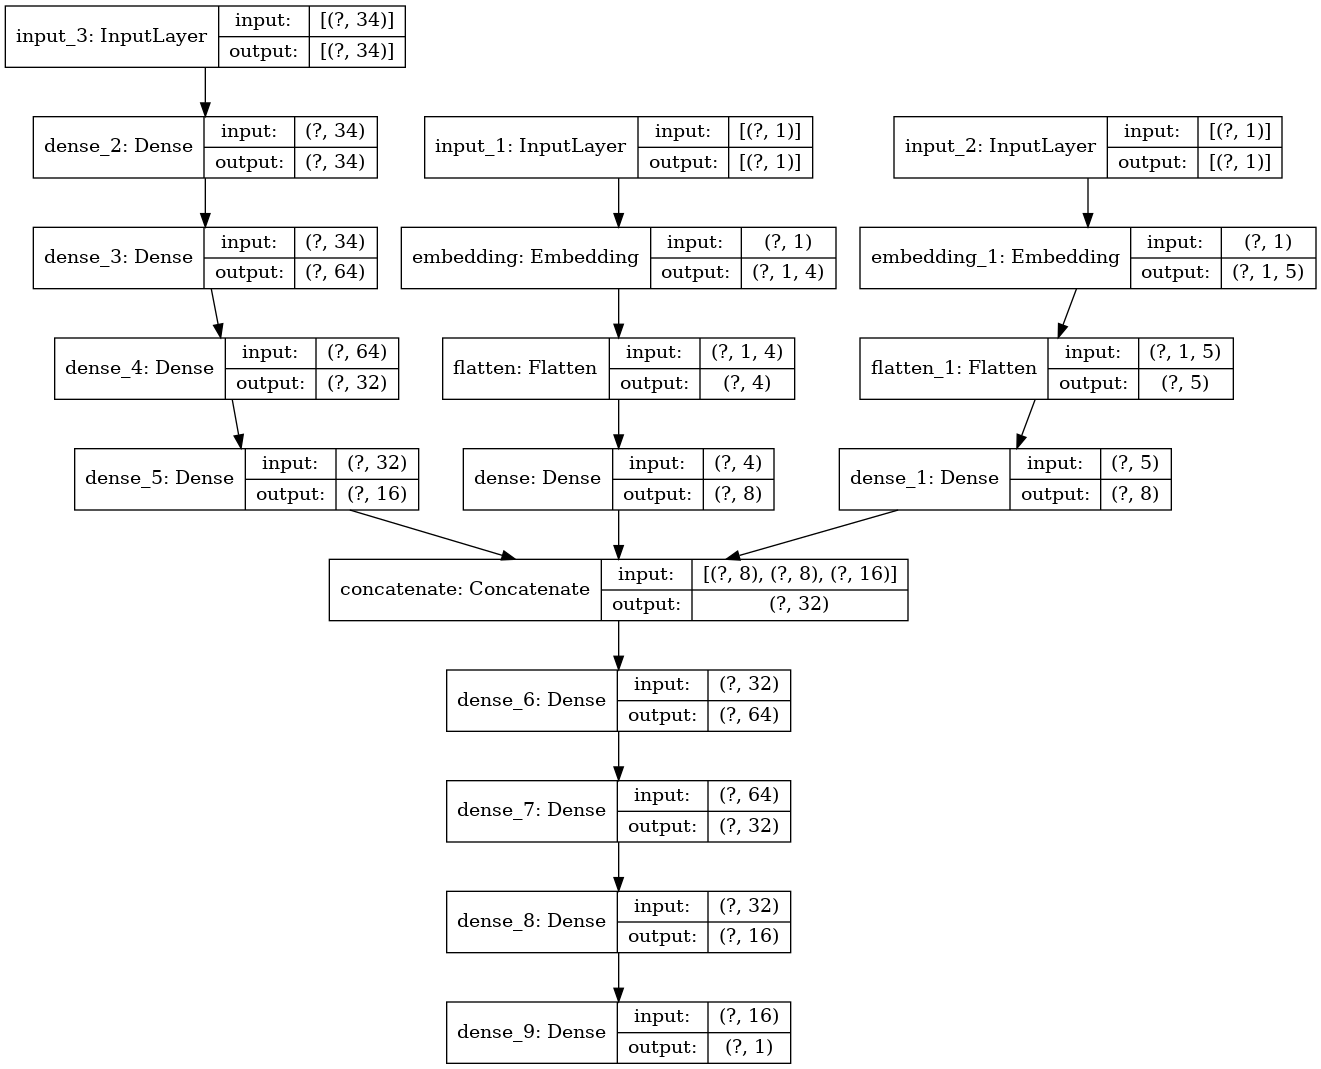

In [22]:
from keras.models import Model
from keras.utils.vis_utils import plot_model
from keras.layers import Dense, Embedding, Flatten, Input, concatenate
from keras.regularizers import l2

def create_emb(emb):
    vin = []
    vou = []
    for i in range(emb.shape[1]):
        nb = np.unique(emb[:,i]).shape[0]
        m  = int(round(nb/2))+1
        #m  = 16
        i  = Input(shape=(1,))
        x  = Embedding(input_dim = nb, output_dim = m, input_length = 1)(i)
        x  = Flatten()(x)
        o  = Dense(8, activation='relu')(x)
        
        vin.append(i)
        vou.append(o)
    return(vin, vou)

def create_model(emb, a):
    vin, vou = create_emb(emb)
    
    i = Input(shape=(a,))
    
    x  = Dense(a, activation='relu')(i)
    x  = Dense(64, activation='relu')(x)
    x  = Dense(32, activation='relu')(x)
    o  = Dense(16, activation='relu')(x)
    
    vin.append(i)
    vou.append(o)
    
    i1  = concatenate(vou)
    x   = Dense(64, activation='relu')(i1)
    x   = Dense(32, activation='relu')(x)
    x   = Dense(16, activation='relu')(x)
    o1  = Dense(1, activation='linear')(x)
    
    return(Model(inputs=vin, outputs=[o1]))

model_nan = create_model(emb, nor.shape[1])
model_nan.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
plot_model(model_nan, to_file='model_nan_plot.png', show_shapes=True, show_layer_names=True)

#### Exécution du calcul du modèle NN d'imputation

In [23]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 3, verbose = 1, mode = 'auto')
history_nan = model_nan.fit([emb[idx_nok,0][ids[0]],emb[idx_nok,1][ids[0]], nor[idx_nok,:][ids[0],:]],
                            [full['OP100_Capuchon_insertion_mesure'].values[idx_nok][ids[0]]],
                            validation_data = ([emb[idx_nok,0][ids[1]], emb[idx_nok,1][ids[1]], nor[idx_nok,:][ids[1],:]],
                                               [full['OP100_Capuchon_insertion_mesure'].values[idx_nok][ids[1]]]),
                            batch_size = 1024, shuffle=False, callbacks=[es], epochs = 500, verbose=1)

Epoch 1/500
13/13 [==============================] - 0s 32ms/step - loss: 0.0182 - mse: 0.0182 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 2/500
13/13 [==============================] - 0s 15ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 3/500
13/13 [==============================] - 0s 15ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 4/500
13/13 [==============================] - 0s 16ms/step - loss: 7.7757e-04 - mse: 7.7757e-04 - val_loss: 5.3663e-04 - val_mse: 5.3663e-04
Epoch 5/500
13/13 [==============================] - 0s 16ms/step - loss: 5.2269e-04 - mse: 5.2269e-04 - val_loss: 4.3792e-04 - val_mse: 4.3792e-04
Epoch 6/500
13/13 [==============================] - 0s 15ms/step - loss: 4.2865e-04 - mse: 4.2865e-04 - val_loss: 3.9700e-04 - val_mse: 3.9700e-04
Epoch 7/500
13/13 [==============================] - 0s 15ms/step - loss: 3.8691e-04 - mse: 3.8691e-04 - val_loss: 3.6410e-04 - val_mse: 3.6410e-04
Epoch 8/500


13/13 [==============================] - 0s 16ms/step - loss: 2.2881e-04 - mse: 2.2881e-04 - val_loss: 2.3013e-04 - val_mse: 2.3013e-04
Epoch 57/500
13/13 [==============================] - 0s 17ms/step - loss: 2.2840e-04 - mse: 2.2840e-04 - val_loss: 2.2979e-04 - val_mse: 2.2979e-04
Epoch 58/500
13/13 [==============================] - 0s 17ms/step - loss: 2.2799e-04 - mse: 2.2799e-04 - val_loss: 2.2950e-04 - val_mse: 2.2950e-04
Epoch 59/500
13/13 [==============================] - 0s 15ms/step - loss: 2.2750e-04 - mse: 2.2750e-04 - val_loss: 2.2921e-04 - val_mse: 2.2921e-04
Epoch 60/500
13/13 [==============================] - 0s 15ms/step - loss: 2.2714e-04 - mse: 2.2714e-04 - val_loss: 2.2892e-04 - val_mse: 2.2892e-04
Epoch 61/500
13/13 [==============================] - 0s 16ms/step - loss: 2.2676e-04 - mse: 2.2676e-04 - val_loss: 2.2863e-04 - val_mse: 2.2863e-04
Epoch 62/500
13/13 [==============================] - 0s 15ms/step - loss: 2.2634e-04 - mse: 2.2634e-04 - val_loss: 2.2

Epoch 111/500
13/13 [==============================] - 0s 16ms/step - loss: 2.1861e-04 - mse: 2.1861e-04 - val_loss: 2.2087e-04 - val_mse: 2.2087e-04
Epoch 112/500
13/13 [==============================] - 0s 15ms/step - loss: 2.1859e-04 - mse: 2.1859e-04 - val_loss: 2.2077e-04 - val_mse: 2.2077e-04
Epoch 113/500
13/13 [==============================] - 0s 15ms/step - loss: 2.1855e-04 - mse: 2.1855e-04 - val_loss: 2.2075e-04 - val_mse: 2.2075e-04
Epoch 114/500
13/13 [==============================] - 0s 15ms/step - loss: 2.1860e-04 - mse: 2.1860e-04 - val_loss: 2.2080e-04 - val_mse: 2.2080e-04
Epoch 115/500
13/13 [==============================] - 0s 16ms/step - loss: 2.1858e-04 - mse: 2.1858e-04 - val_loss: 2.2071e-04 - val_mse: 2.2071e-04
Epoch 116/500
13/13 [==============================] - 0s 16ms/step - loss: 2.1854e-04 - mse: 2.1854e-04 - val_loss: 2.2073e-04 - val_mse: 2.2073e-04
Epoch 117/500
13/13 [==============================] - 0s 16ms/step - loss: 2.1853e-04 - mse: 2.1853

#### Visualisation du résultat sur le jeu de validation

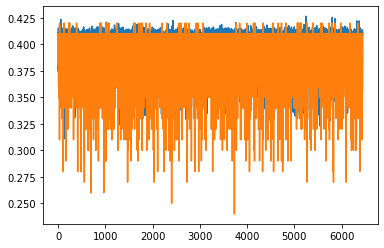

In [24]:
import matplotlib.pyplot as plt
plt.plot(model_nan.predict([emb[idx_nok,0][ids[1]],emb[idx_nok,1][ids[1]],nor[idx_nok,:][ids[1],:]]))
plt.plot(full['OP100_Capuchon_insertion_mesure'].values[idx_nok][ids[1]])

#### Remplacement des NaN avec le résultat issu du modèle NN d'imputation obtenu ci-avant

In [25]:
full['OP100_Capuchon_insertion_mesure'].iloc[idx_nan] = model_nan.predict([emb[idx_nan,0],emb[idx_nan,1],nor[idx_nan,:]]).reshape(22987,)
full.isna().sum()

/home/python/anaconda3/envs/my_env/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


OP070_V_1_angle_value              0
OP090_SnapRingPeakForce_value      0
OP070_V_2_angle_value              0
OP120_Rodage_I_mesure_value        0
OP090_SnapRingFinalStroke_value    0
OP110_Vissage_M8_torque_value      0
OP100_Capuchon_insertion_mesure    0
OP120_Rodage_U_mesure_value        0
OP070_V_1_torque_value             0
OP090_StartLinePeakForce_value     0
OP110_Vissage_M8_angle_value       0
OP090_SnapRingMidPointForce_val    0
OP070_V_2_torque_value             0
day                                0
count                              0
day_count                          0
month_count                        0
monthx                             0
monthy                             0
wdayx                              0
wdayy                              0
dayx                               0
dayy                               0
we                                 0
count_cumsum                       0
countx                             0
county                             0
p

#### Recréation du dataset contenant toutes les variables quantitatives y compris celle qui vient d'être imputée

In [26]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
nor    = scaler.fit_transform(full)

## Elaboration du modèle prédictif attendu dans ce challenge

### Split du dataset d'entrainement en deux (sous) jeux : Train (0.75) / Valid (0.25)

In [27]:
from sklearn.model_selection import train_test_split
tr, va, ytr, yva = train_test_split(np.column_stack((emb,nor))[:shp,:], 
                                    y['Binar OP130_Resultat_Global_v'].values, 
                                    test_size=0.25, random_state=42)
x = emb.shape[1]
emb_tr = tr[:,:x]
emb_va = va[:,:x]
nor_tr = tr[:,x:]
nor_va = va[:,x:]
print(x)

2


### Ré équilibrage du jeu données pour la Target

     - Du fait du déséquilibre important des classes (~ 10% pour la classe minoritaire)
     - Utilisé dans certaines tentatives à des degrés plus ou moins importants 

### Spécification du modèle prédictif (NN)

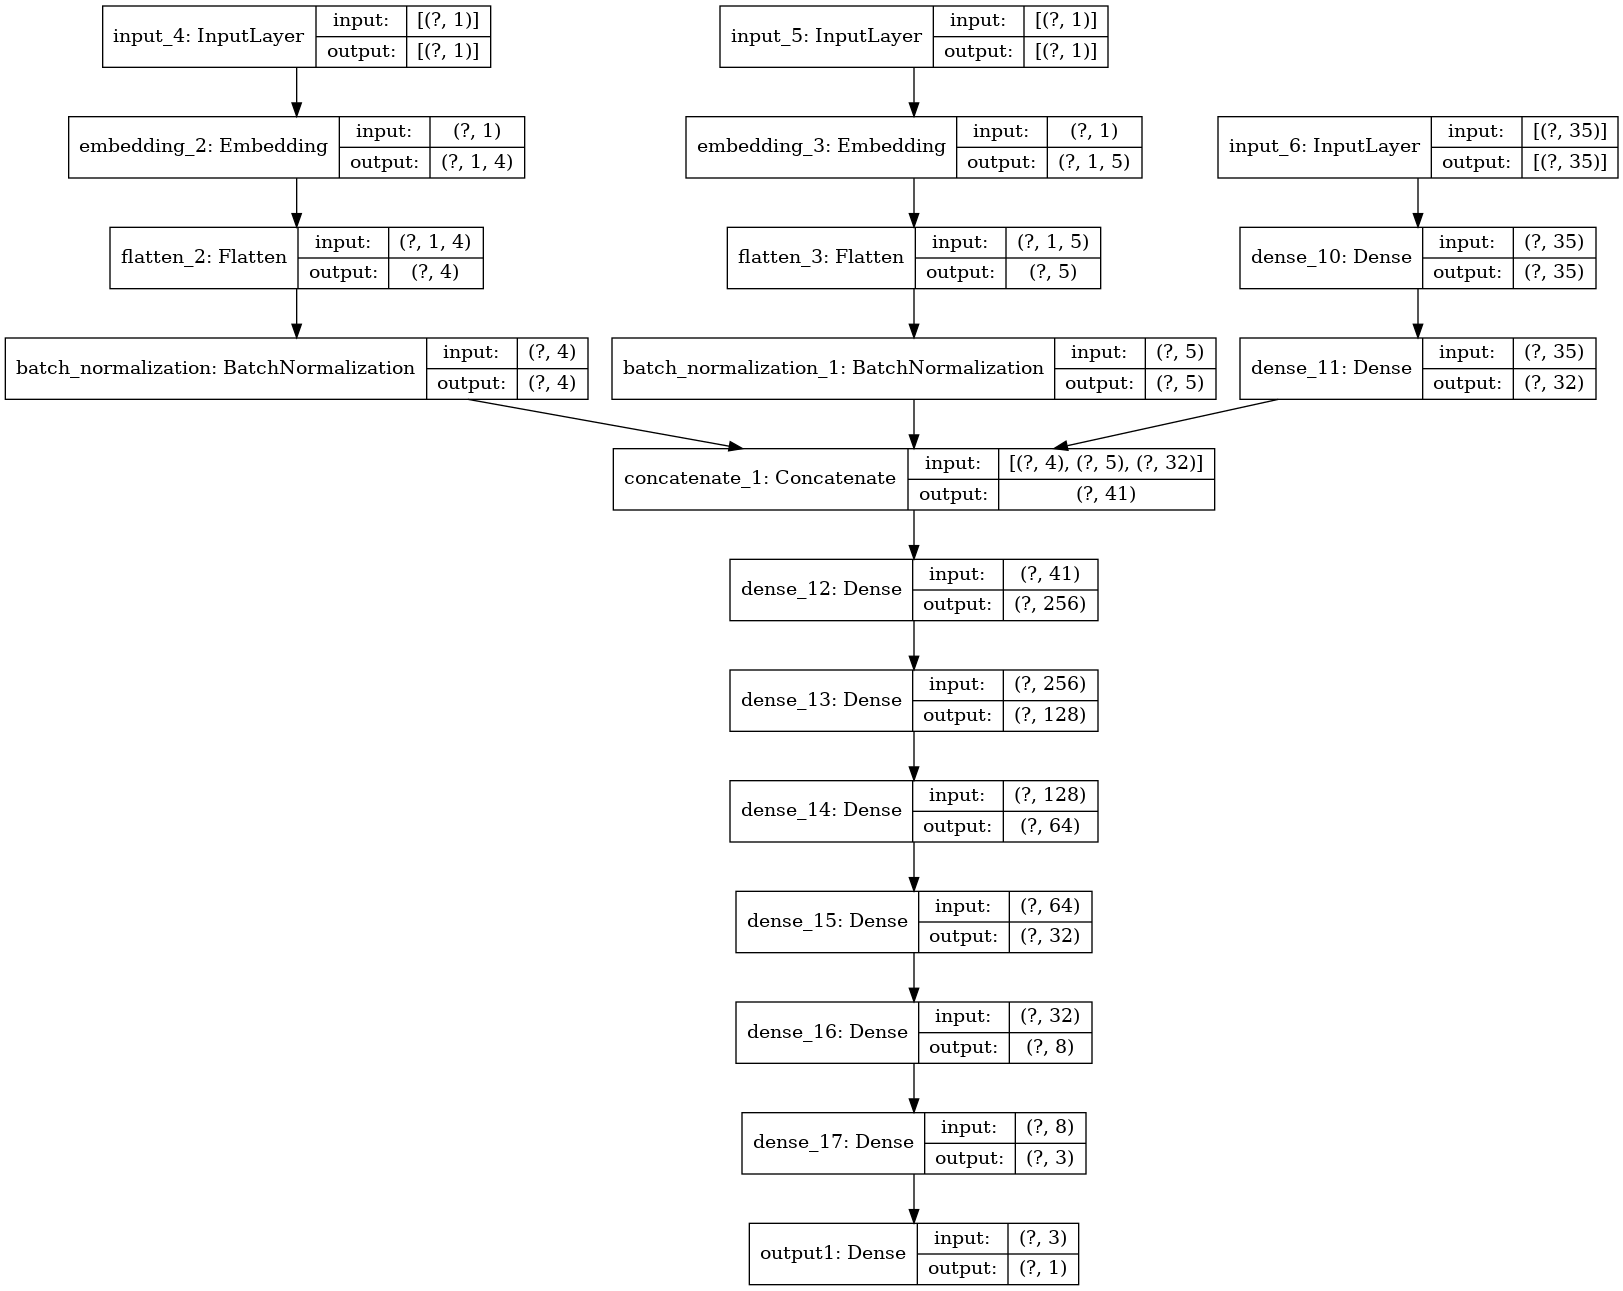

In [30]:
from keras.models import Model
from keras.utils.vis_utils import plot_model
from keras.layers import Dense, Embedding, Flatten, Input, concatenate, Dropout, average, BatchNormalization

def create_emb(emb):
    vin = []
    vou = []
    for i in range(emb.shape[1]):
        
        nb = np.unique(emb[:,i]).shape[0]
        m  = int(round(nb/2))+1
        i  = Input(shape=(1,))
        x  = Embedding(input_dim = nb, output_dim = m, input_length = 1)(i)
        x  = Flatten()(x)
        o  = BatchNormalization()(x)
        
        vin.append(i)
        vou.append(o)
    return(vin, vou)

def create_model(emb, a):
    vin, vou = create_emb(emb)
    
    i = Input(shape=(a,))
    x  = Dense(a, activation='relu')(i)
    o  = Dense(32, activation='relu')(x)
        
    vin.append(i)
    vou.append(o)
    
    i1 = concatenate(vou)
    x  = Dense(256, activation='relu')(i1)
    x  = Dense(128, activation='relu')(x)
    x  = Dense(64, activation='relu')(x)
    x  = Dense(32, activation='relu')(x)
    x  = Dense(8, activation='relu')(x)
    x  = Dense(3, activation='relu')(x)
    o1 = Dense(1, activation='sigmoid', name="output1")(x)
    
    return(Model(inputs=vin, outputs=[o1]))

model = create_model(emb, nor.shape[1])
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Implémentation d'un CallBack (plus graphique, gestion par époques & sauvegarde du meilleur modèle)

In [31]:
from keras.utils import to_categorical
from keras import callbacks
from keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score, precision_recall_curve, f1_score
from sklearn.preprocessing import MinMaxScaler

import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output
matplotlib.rc('figure', max_open_warning = 0)

class MyCustomCallback(callbacks.Callback):
    def on_train_batch_begin(self, batch, logs=None):
        return()
    def on_train_batch_end(self, batch, logs=None):
        return()
    def on_test_batch_begin(self, batch, logs=None):
        return()
    def on_test_batch_end(self, batch, logs=None):
        return()
    def on_test_begin(self, logs=None):
        return()
    def on_test_end(self, logs=None):
        return()
    def on_train_begin(self, logs={}):
        self.max_auc  = 0.95
        self.best_auc = 0.0
        self.best_thr = 0.0
        self.i = 0
        self.x = []
        self.auc = []
        self.val_auc = []
        self.fig = plt.figure()
        self.logs = []
        
    def on_epoch_end(self, epoch, logs=None):
        y_pred  = self.model.predict([emb_tr[:,0], emb_tr[:,1], nor_tr])
        auc     = roc_auc_score(ytr, y_pred)
        
        y_pred  = self.model.predict([emb_va[:,0], emb_va[:,1], nor_va])
        val_auc = roc_auc_score(yva, y_pred)
        
        self.x.append(self.i)
        self.auc.append(auc)
        self.val_auc.append(val_auc)
        self.i += 1
        
        clear_output(wait=True)
        plt.clf()
        plt.plot(self.x, self.auc, label="AUC ROC")
        plt.plot(self.x, self.val_auc, label="val AUC ROC")
        plt.legend()
        plt.show();
        
        print(str(self.i), "] Current tr. AUC ROC : ", auc, " | val. AUC ROC : ", val_auc, " (Best val. : ", self.best_auc, ")", sep="")
        if self.best_auc < val_auc:
            print("-----> Saving new best model ... (Old best AUC : ", self.best_auc, " | New best AUC : ", val_auc, ")", sep = "")
            self.best_auc = val_auc
            self.model.save('tmp_best.h5')
        if self.best_auc > self.max_auc:
            self.model.stop_training = True

### Calcul du paramètre 'weight' de la fonction 'fit' (équilibrage des données pendant l'exécution du NN)

In [32]:
from sklearn.utils.class_weight import compute_class_weight
cw = compute_class_weight('balanced', np.unique(ytr), ytr)
cw[1]/cw[0]

/home/python/anaconda3/envs/my_env/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 1 0 ... 0 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


112.03930131004367

### Exécution du calcul du modèle prédictif (NN)

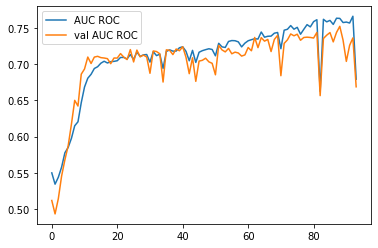

94] Current tr. AUC ROC : 0.6794208038086597 | val. AUC ROC : 0.6689427224673399 (Best val. : 0.7525645049136345)


KeyboardInterrupt: 

In [33]:
from sklearn.utils.class_weight import compute_class_weight
es = MyCustomCallback()
history = model.fit(x = [emb_tr[:,0], emb_tr[:,1], nor_tr], y=ytr,
                    validation_data = ([emb_va[:,0], emb_va[:,1], nor_va], yva),
                    class_weight={0:1.,1:(cw[1]/cw[0])}, 
                    steps_per_epoch = None,
                    batch_size = 1024, shuffle=True, callbacks=[es], 
                    epochs = 250, verbose=0)

## Elaboration du jeu de données à soumettre sur le jeu de test

### Récupération du meilleur modèle enregistré suite au processus de calcul précédent

In [34]:
from keras.models import load_model
mod = load_model('tmp_best.h5')

### Visualisation des performances obtenues en phase d'entrainement du modèle

In [35]:
y_pred_tr = mod.predict([emb_tr[:,0],emb_tr[:,1],nor_tr])
y_pred_va = mod.predict([emb_va[:,0],emb_va[:,1],nor_va])

print("TRAIN : ", roc_auc_score(ytr, y_pred_tr))
print("VALID : ", roc_auc_score(yva, y_pred_va))

TRAIN :  0.7635384029112309
VALID :  0.7525645049136345


### Enregistrement du jeu de données définitif à soumettre

In [ ]:
y_pred_te = scaler.fit_transform(mod.predict([emb[shp:,0], emb[shp:,1], nor[shp:,:]]))
np.set_printoptions(suppress=True)
out = np.column_stack((tid,y_pred_te))
fstr = "output_2020mmdd_valeo_x.csv"
np.savetxt(fstr, out, delimiter=",", comments = "",
           header="PROC_TRACEINFO,Binar OP130_Resultat_Global_v", fmt="%s")
mod.save(fstr+'.h5')
model_nan.save(fstr+'_nan.h5')